In [21]:
import pandas as pd
import numpy as np
import datetime
import warnings
import joblib
import os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [22]:
file_list = []
for root_dir,sub_dir,files in os.walk('./data'):
    file_list.append(files)
file_list = file_list[0]
dataframe_list = pd.DataFrame()
for file in files:
    if file.endswith('xlsx'):
        file_name = os.path.join(root_dir,file)
        df = pd.read_excel(file_name)
        dataframe_list = dataframe_list.append(df)

In [23]:
dataframe_list.shape

(466200, 18)

In [24]:
dataframe_list.drop('新建角色数',axis=1,inplace=True)
dataframe_list.columns = ['channel_id','source_id','data_win','model_run_datetime','create_time',
                         'game_id','platform','source_run_date_amount','create_role_num','create_role_cost','create_role_pay_num',
                          'create_role_pay_cost','create_role_pay_sum','create_role_roi','create_role_retain_1d','create_role_pay_rate',
                         'create_role_30_pay_sum']
dataframe_list.dropna(how='any',inplace=True)

In [26]:
dataframe_list = dataframe_list[dataframe_list['source_run_date_amount'] > 0]
dataframe_list.sort_values(by='data_win',inplace=True)
dataframe_list.drop_duplicates(subset=['channel_id','source_id','source_run_date_amount','create_role_num'],keep='first'
                               ,inplace=True)

In [27]:
dataframe_list.shape

(106964, 17)

In [28]:
dataframe_list.head()

,channel_id,source_id,data_win,model_run_datetime,create_time,game_id,platform,source_run_date_amount,create_role_num,create_role_cost,create_role_pay_num,create_role_pay_cost,create_role_pay_sum,create_role_roi,create_role_retain_1d,create_role_pay_rate,create_role_30_pay_sum
0,20451,304184,0,2020-05-01,2020-04-30,1000840,1,29.31,3,9.770000,0,0.0,0,0.0,0.6667,0.0,12
11255,6867,317896,0,2020-06-27,2020-06-09,1001049,1,45.61,3,15.203333,0,0.0,0,0.0,0.0000,0.0,0
11256,6867,317898,0,2020-06-27,2020-06-09,1001049,1,37.11,2,18.555000,0,0.0,0,0.0,0.0000,0.0,0
11257,6867,318308,0,2020-06-27,2020-06-10,1001049,1,24.43,2,12.215000,0,0.0,0,0.0,0.0000,0.0,0
11258,6867,318975,0,2020-06-27,2020-06-12,1001049,1,1542.94,28,55.105000,0,0.0,0,0.0,0.0357,0.0,12


In [30]:
data_win3 = dataframe_list[dataframe_list['data_win']==3]

In [31]:
source_image = pd.read_csv('./source_image.csv')

In [36]:
source_image = source_image[['channel_id','source_id','image_id']].drop_duplicates()

In [37]:
source_image.head()

,channel_id,source_id,image_id
0,20953,252731,18072.0
1,20953,252732,18563.0
2,20953,252733,19254.0
3,20953,252798,16276.0
4,20953,252799,18435.0


In [39]:
data_win3_1 = pd.merge(data_win3,source_image,on=['channel_id','source_id'],how='left',validate='many_to_one')

In [40]:
data_win3_1.shape

(12362, 18)

In [61]:
data_win3_1.head()

,channel_id,source_id,data_win,model_run_datetime,create_time,game_id,platform,source_run_date_amount,create_role_num,create_role_cost,create_role_pay_num,create_role_pay_cost,create_role_pay_sum,create_role_roi,create_role_retain_1d,create_role_pay_rate,create_role_30_pay_sum,image_id,create_role_retain_1d_num
0,20540,332599,3,2020-07-23,2020-07-18,1000840,1,177.21,5,35.442000,0,0.000000,0,0.000000,0.0000,0.00000,0,23528.0,0.0000
1,20540,332600,3,2020-07-23,2020-07-18,1000840,1,739.57,39,18.963333,0,0.000000,0,0.000000,0.0769,0.00000,0,23528.0,2.9991
2,20540,332602,3,2020-07-23,2020-07-18,1000840,1,5138.53,581,8.844286,1,5138.530000,30,0.005838,0.0809,0.00172,236,23528.0,47.0029
3,20646,332609,3,2020-07-23,2020-07-18,1000840,1,16128.08,992,16.258145,15,1075.205333,1322,0.081969,0.1058,0.01512,2032,23528.0,104.9536
4,20646,332624,3,2020-07-23,2020-07-18,1000840,1,1189.27,73,16.291370,0,0.000000,0,0.000000,0.0822,0.00000,0,23552.0,6.0006


In [54]:
data_win3_1['create_role_retain_1d_num'] = data_win3_1['create_role_retain_1d'] * data_win3_1['create_role_num']

In [55]:
groups = data_win3_1.groupby(['image_id','model_run_datetime'])
groups.ngroups

3196

In [56]:
temp = groups['source_run_date_amount'].agg([('image_amount_sum','sum')]).reset_index()
matrix = pd.merge(data_win3_1,temp,on=['image_id','model_run_datetime'],how='left')

In [57]:
temp = groups['create_role_num'].agg([('image_create_role_num','sum')]).reset_index()
matrix = pd.merge(matrix,temp,on=['image_id','model_run_datetime'],how='left')

In [58]:
temp = groups['create_role_pay_num'].agg([('image_create_role_pay_num','sum')]).reset_index()
matrix = pd.merge(matrix,temp,on=['image_id','model_run_datetime'],how='left')

In [59]:
temp = groups['create_role_pay_sum'].agg([('image_create_role_pay_sum','sum')]).reset_index()
matrix = pd.merge(matrix,temp,on=['image_id','model_run_datetime'],how='left')

In [60]:
temp = groups['create_role_30_pay_sum'].agg([('image_create_role_30_pay_sum','sum')]).reset_index()
matrix = pd.merge(matrix,temp,on=['image_id','model_run_datetime'],how='left')

In [62]:
temp = groups['create_role_retain_1d_num'].agg([('image_create_role_retain_1d_num','sum')]).reset_index()
matrix = pd.merge(matrix,temp,on=['image_id','model_run_datetime'],how='left')

In [63]:
matrix.head()

,channel_id,source_id,data_win,model_run_datetime,create_time,game_id,platform,source_run_date_amount,create_role_num,create_role_cost,create_role_pay_num,create_role_pay_cost,create_role_pay_sum,create_role_roi,create_role_retain_1d,create_role_pay_rate,create_role_30_pay_sum,image_id,create_role_retain_1d_num,image_amount_sum,image_create_role_num,image_create_role_pay_num,image_create_role_pay_sum,image_create_role_30_pay_sum,image_create_role_retain_1d_num
0,20540,332599,3,2020-07-23,2020-07-18,1000840,1,177.21,5,35.442000,0,0.000000,0,0.000000,0.0000,0.00000,0,23528.0,0.0000,484687.95,12171.0,150.0,26594.0,63870.0,1163.8339
1,20540,332600,3,2020-07-23,2020-07-18,1000840,1,739.57,39,18.963333,0,0.000000,0,0.000000,0.0769,0.00000,0,23528.0,2.9991,484687.95,12171.0,150.0,26594.0,63870.0,1163.8339
2,20540,332602,3,2020-07-23,2020-07-18,1000840,1,5138.53,581,8.844286,1,5138.530000,30,0.005838,0.0809,0.00172,236,23528.0,47.0029,484687.95,12171.0,150.0,26594.0,63870.0,1163.8339
3,20646,332609,3,2020-07-23,2020-07-18,1000840,1,16128.08,992,16.258145,15,1075.205333,1322,0.081969,0.1058,0.01512,2032,23528.0,104.9536,484687.95,12171.0,150.0,26594.0,63870.0,1163.8339
4,20646,332624,3,2020-07-23,2020-07-18,1000840,1,1189.27,73,16.291370,0,0.000000,0,0.000000,0.0822,0.00000,0,23552.0,6.0006,21606.18,1105.0,8.0,562.0,2810.0,96.0227


In [84]:
image_info = matrix[['image_id','model_run_datetime','image_amount_sum','image_create_role_num',
                     'image_create_role_pay_num','image_create_role_pay_sum','image_create_role_30_pay_sum','image_create_role_retain_1d_num']].drop_duplicates()

In [85]:
image_info.shape

(3223, 8)

In [86]:
image_info.head()

,image_id,model_run_datetime,image_amount_sum,image_create_role_num,image_create_role_pay_num,image_create_role_pay_sum,image_create_role_30_pay_sum,image_create_role_retain_1d_num
0,23528.0,2020-07-23,484687.95,12171.0,150.0,26594.0,63870.0,1163.8339
4,23552.0,2020-07-23,21606.18,1105.0,8.0,562.0,2810.0,96.0227
6,23067.0,2020-07-23,188172.72,4970.0,66.0,12968.0,132066.0,540.0019
7,21388.0,2020-06-05,49052.32,3355.0,16.0,750.0,4452.0,132.0150
8,20819.0,2020-06-05,28915.05,875.0,11.0,2072.0,8940.0,52.9935


In [87]:
image_info.drop(image_info[image_info['image_id'].isna()].index,inplace=True)

In [92]:
image_info.sort_values('image_create_role_cost')

,image_id,model_run_datetime,image_amount_sum,image_create_role_num,image_create_role_pay_num,image_create_role_pay_sum,image_create_role_30_pay_sum,image_create_role_retain_1d_num,image_create_role_cost,image_create_role_pay_cost,image_create_role_roi
6919,20751.0,2020-05-19,20.02,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
6331,21194.0,2020-05-04,46.86,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
310,21174.0,2020-06-23,1.13,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
1513,21194.0,2020-05-03,7.44,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
306,21624.0,2020-06-23,1033.52,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11402,22207.0,2020-06-16,1791.99,2.0,0.0,0.0,0.0,0.0,895.995,0.0,0.0
4063,21967.0,2020-06-08,1084.50,1.0,0.0,0.0,0.0,0.0,1084.500,0.0,0.0
8382,21092.0,2020-05-01,1220.24,1.0,0.0,0.0,0.0,0.0,1220.240,0.0,0.0
27,21967.0,2020-06-05,1293.46,1.0,0.0,0.0,0.0,0.0,1293.460,0.0,0.0


In [95]:
image_info['image_create_role_cost'] = image_info['image_amount_sum'] / image_info['image_create_role_num']
image_info['image_create_role_pay_cost'] = image_info['image_amount_sum'] / image_info['image_create_role_pay_num']
image_info['image_create_role_roi'] = image_info['image_create_role_pay_sum'] / image_info['image_amount_sum']
image_info['image_create_role_retain_1d'] = image_info['image_create_role_retain_1d_num'] / image_info['image_create_role_num']
image_info['image_create_role_pay_rate'] = image_info['image_create_role_pay_num'] / image_info['image_create_role_num']
image_info['image_30_roi'] = image_info['image_create_role_30_pay_sum'] / image_info['image_amount_sum']
image_info.replace([np.inf, -np.inf], 0,inplace=True)

In [96]:
image_info.head()

,image_id,model_run_datetime,image_amount_sum,image_create_role_num,image_create_role_pay_num,image_create_role_pay_sum,image_create_role_30_pay_sum,image_create_role_retain_1d_num,image_create_role_cost,image_create_role_pay_cost,image_create_role_roi,image_create_role_retain_1d,image_create_role_pay_rate,image_30_roi
0,23528.0,2020-07-23,484687.95,12171.0,150.0,26594.0,63870.0,1163.8339,39.823182,3231.253000,0.054868,0.095624,0.012324,0.131776
4,23552.0,2020-07-23,21606.18,1105.0,8.0,562.0,2810.0,96.0227,19.553104,2700.772500,0.026011,0.086898,0.007240,0.130055
6,23067.0,2020-07-23,188172.72,4970.0,66.0,12968.0,132066.0,540.0019,37.861714,2851.101818,0.068915,0.108652,0.013280,0.701834
7,21388.0,2020-06-05,49052.32,3355.0,16.0,750.0,4452.0,132.0150,14.620662,3065.770000,0.015290,0.039349,0.004769,0.090760
8,20819.0,2020-06-05,28915.05,875.0,11.0,2072.0,8940.0,52.9935,33.045771,2628.640909,0.071658,0.060564,0.012571,0.309182


In [119]:
image_info[['image_amount_sum','image_create_role_num','image_create_role_pay_num','image_create_role_pay_sum'
           ,'image_create_role_30_pay_sum','image_create_role_retain_1d_num','image_create_role_cost',
            'image_create_role_pay_cost','image_create_role_roi','image_create_role_retain_1d',
            'image_create_role_pay_rate','image_30_roi']].corr()['image_30_roi'].sort_values(ascending=False)

image_30_roi                       1.000000
image_create_role_roi              0.726540
image_create_role_pay_rate         0.162913
image_create_role_30_pay_sum       0.060830
image_create_role_retain_1d        0.056763
image_create_role_pay_sum          0.019991
image_create_role_pay_num          0.005062
image_create_role_num              0.002236
image_create_role_retain_1d_num    0.000822
image_amount_sum                  -0.002354
image_create_role_cost            -0.025062
image_create_role_pay_cost        -0.026976
Name: image_30_roi, dtype: float64

In [125]:
corr_data_csv = image_info[['image_amount_sum','image_create_role_num','image_create_role_pay_num','image_create_role_pay_sum'
           ,'image_create_role_30_pay_sum','image_create_role_retain_1d_num','image_create_role_cost',
            'image_create_role_pay_cost','image_create_role_roi','image_create_role_retain_1d',
            'image_create_role_pay_rate','image_30_roi']].corr()['image_30_roi'].sort_values(ascending=False)
corr_data_csv.to_csv('./corr_data.csv')

In [121]:
corr_data = image_info[['image_amount_sum','image_create_role_num','image_create_role_pay_num','image_create_role_pay_sum'
           ,'image_create_role_30_pay_sum','image_create_role_retain_1d_num','image_create_role_cost',
            'image_create_role_pay_cost','image_create_role_roi','image_create_role_retain_1d',
            'image_create_role_pay_rate','image_30_roi']]

In [100]:
import matplotlib.pyplot as plt

In [113]:
xlabel =corr_data.index.tolist()

In [114]:
xlabel

['image_30_roi',
 'image_create_role_roi',
 'image_create_role_pay_rate',
 'image_create_role_30_pay_sum',
 'image_create_role_retain_1d',
 'image_create_role_pay_sum',
 'image_create_role_pay_num',
 'image_create_role_num',
 'image_create_role_retain_1d_num',
 'image_amount_sum',
 'image_create_role_cost',
 'image_create_role_pay_cost']

In [126]:
image_info_10000 = image_info[image_info['image_amount_sum']<10000]

In [127]:
corr_data_10000 = image_info_10000[['image_amount_sum','image_create_role_num','image_create_role_pay_num','image_create_role_pay_sum'
           ,'image_create_role_30_pay_sum','image_create_role_retain_1d_num','image_create_role_cost',
            'image_create_role_pay_cost','image_create_role_roi','image_create_role_retain_1d',
            'image_create_role_pay_rate','image_30_roi']]

In [130]:
image_info_10000[['image_amount_sum','image_create_role_num','image_create_role_pay_num','image_create_role_pay_sum'
           ,'image_create_role_retain_1d_num','image_create_role_cost',
            'image_create_role_pay_cost','image_create_role_roi','image_create_role_retain_1d',
            'image_create_role_pay_rate','image_30_roi']].corr()['image_30_roi'].sort_values(ascending=False)

image_30_roi                       1.000000
image_create_role_roi              0.728245
image_create_role_pay_rate         0.165267
image_create_role_pay_sum          0.095594
image_create_role_retain_1d        0.059120
image_create_role_pay_num          0.038599
image_create_role_retain_1d_num   -0.014569
image_create_role_pay_cost        -0.016543
image_create_role_num             -0.025295
image_create_role_cost            -0.026394
image_amount_sum                  -0.044363
Name: image_30_roi, dtype: float64

In [132]:
image_info_10000_up = image_info[image_info['image_amount_sum']>10000]

In [133]:
image_info_10000_up[['image_amount_sum','image_create_role_num','image_create_role_pay_num','image_create_role_pay_sum'
           ,'image_create_role_retain_1d_num','image_create_role_cost',
            'image_create_role_pay_cost','image_create_role_roi','image_create_role_retain_1d',
            'image_create_role_pay_rate','image_30_roi']].corr()['image_30_roi'].sort_values(ascending=False)

image_30_roi                       1.000000
image_create_role_roi              0.606593
image_create_role_pay_sum          0.205276
image_create_role_pay_rate         0.134924
image_create_role_pay_num          0.085365
image_create_role_num              0.074487
image_create_role_retain_1d_num    0.068493
image_amount_sum                   0.048375
image_create_role_retain_1d       -0.023226
image_create_role_cost            -0.057819
image_create_role_pay_cost        -0.225397
Name: image_30_roi, dtype: float64

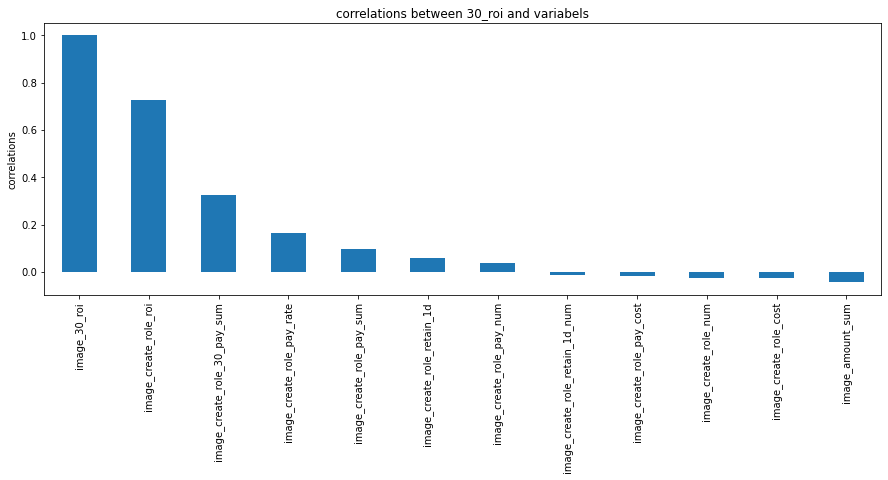

In [128]:
# 与各变量之间的相关性
plt.figure(figsize=(15,5))
corr_data_10000.corr()['image_30_roi'].sort_values(ascending=False).plot(kind='bar')
plt.ylabel('correlations')
plt.title('correlations between 30_roi and variabels')
plt.show()

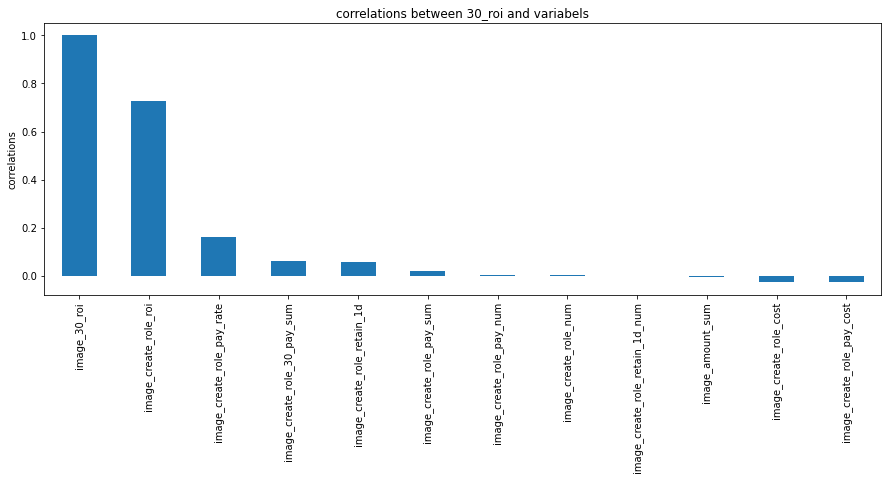

In [124]:
# 与各变量之间的相关性
plt.figure(figsize=(15,5))
corr_data.corr()['image_30_roi'].sort_values(ascending=False).plot(kind='bar')
plt.ylabel('correlations')
plt.title('correlations between 30_roi and variabels')
plt.show()